## Libraries we're using (and may possibly use...)


In [1]:
%matplotlib inline                  
import matplotlib                   # make plots show up in notebook
import time                         # time/date parser
import csv                          # data parser
import numpy as np                  # arrays for plotting
import matplotlib.pyplot as plt     # plotting
import math                         # ceiling for y-max in plots
import twitter_criteria as twc      # yaml, re, os

# Possible libraries we'll use, included them for now
import nltk
import pandas as pd
import sklearn as sl


## Retrieving useful data with our `twitter_criteria` module

In [2]:
# open criteria .yml file and load it into global dictionary in twc using yaml
twc.loadCriteria()

# retrieve the time format string from the criteria dictionary in twc
tweet_time_fmt = twc.getTwitterTimeFmt()

# build regex pattern for searching for all the keywords
# Will look something like '#bostonmarathon|#marathonmonday|#patriotsday|marathon|...'
keywords = twc.getKeywordRegex()

# initialze hash/dictionary for counting keyword occurances
keyword_counts = {}
for word in twc.getKeywords():
    keyword_counts[word] = 0

# free additional memory used for criteria dictionary
twc.clearCriteria()


## Functions

In [3]:

def tweetContainsKeyWords(tweet):
    # searches tweet for keywords, if none were found, findall returns empty list
    found_words = keywords.findall(tweet)
    if found_words:
        for word in found_words:
            keyword_counts[word] += 1
        return True
    else:
        return False

def makePlot(dates, month):
    ### produce subplots
    ### source: http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html
  
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121) # 1x2 grid, 1st subplot

    #### make data plot-friendly

    bar_width = 0.35
    indices = np.arange(len(dates))

    ams = []
    pms = []
    tickMarks = []

    # goes through the date hashes in order of day
    for d in sorted(dates):
        # adds the day's counts to each list respectively
        ams.append(dates[d]['AM'])
        pms.append(dates[d]['PM'])
        # make string representing and add it to list
        tickMarks.append(str(month) + '/' + str(d))

    ##### get largest count of both lists and round up to nearest 100th
    maxCount = int(math.ceil(max(ams + pms) / 100.0)) * 100

    #### plot data

    ##### first plot

    amBars = ax.bar(indices, ams, bar_width, color='c')

    pmBars = ax.bar(indices+bar_width, pms, bar_width, color='g')

    ax.set_xlim(-bar_width, len(indices)+bar_width)
    ax.set_ylim(0, maxCount)
    ax.set_ylabel('Number of Tweets')
    ax.set_title('Tweets Containing Keywords per Day', fontsize=10)
    ax.set_xticks(indices+bar_width)
    tickNames = ax.set_xticklabels(tickMarks)
    plt.setp(tickNames, rotation=45, fontsize=10)

    ax.legend((amBars[0], pmBars[0]), ('AM', 'PM'))

    ##### second plot, keyword count
    #source (simple way): http://stackoverflow.com/questions/17232683/creating-tables-in-matplotlib
    
    colLabs = ['Keyword', 'Frequency']

    table_data = []
    for word in sorted(keyword_counts, key=keyword_counts.get, reverse=True):
        table_data.append([word, keyword_counts[word]])
    
    ax2 = fig.add_subplot(122) # 1x2, 2nd subplot
    ax2.axis('off') # makes blank subplot
    
    # add title and text
    ax2.set_title('Frequencies of Keywords')
    ax2.table(loc='center', colLabels=colLabs, cellText=table_data)

    
    #### save plots as image
    plt.savefig('tweets_per_day.png', dpi=96)
    plt.show()
    return


## Main

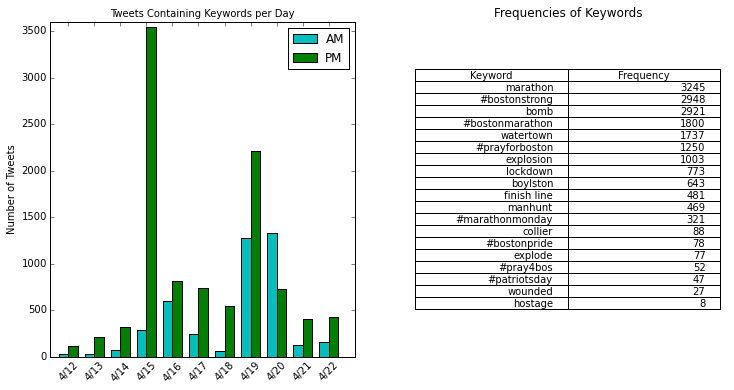

In [4]:
def main():

    ### get data

    dates = {}

    with open('cleaned_geo_tweets_Apr_12_to_22.csv') as csvfile:
        # reads first line of csv to determine keys for the tweet hash, tweets 
        # is an iterator through the list of tweet hashes the DictReader makes
        tweets = csv.DictReader(csvfile)
        # for all the tweets the reader finds
        for tweetData in tweets:
            # make sure its not a 'false tweet' from people using newlines in their tweet_text's
            if tweetData['time'] != "":
                # parse date/time into object
                date = time.strptime(tweetData['time'], tweet_time_fmt)
                # add day hash to list if it hasn't been added
                if not date.tm_mday in dates.keys():
                    dates[date.tm_mday] = {'AM':0, 'PM':0}
                tweetData['tweet_text'] = tweetData['tweet_text'].lower()
                if tweetContainsKeyWords(tweetData['tweet_text']):
                    # determine if morning or evening
                    if date.tm_hour < 12:                     # hour = 0 - 11
                        dates[date.tm_mday]['AM'] += 1
                    else:                                     # hour = 12 - 23
                        dates[date.tm_mday]['PM'] += 1

    makePlot(dates, date.tm_mon)


## if this program is being executed, and not used as a module, call main
if __name__ == "__main__":
    main()

